# Machine Learning Fundamentals: Data Cleaning, Labeling, and Normalization

## Introduction

Welcome to this hands-on exercise on data preprocessing for machine learning! In this notebook, you'll work with a gene expression dataset to classify cancer vs. normal tissue samples.

**The catch**: The data is messy (just like real-world data!). You'll need to clean, label, and normalize it before building effective models.

### Learning Goals
1. Handle missing values, duplicates, and outliers
2. Standardize inconsistent labels
3. Apply and compare normalization techniques
4. Understand the impact of preprocessing on model performance
5. Avoid common pitfalls like data leakage

**Estimated time**: 60 minutes

---

## Setup: Import Libraries

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Display settings
pd.set_option('display.max_columns', 20)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

## Load the Data

We have two CSV files:
- `gene_expression_data.csv`: Expression values for 50 genes across samples
- `sample_metadata.csv`: Diagnosis labels and patient information

In [2]:
# Load datasets
expression_df = pd.read_csv('gene_expression_data.csv')
metadata_df = pd.read_csv('sample_metadata.csv')

print("Expression data shape:", expression_df.shape)
print("Metadata shape:", metadata_df.shape)
print("\nFirst few rows of expression data:")
display(expression_df.head())
print("\nFirst few rows of metadata:")
display(metadata_df.head())

Expression data shape: (104, 51)
Metadata shape: (100, 4)

First few rows of expression data:


,sample_id,GENE_001,GENE_002,GENE_003,GENE_004,GENE_005,GENE_006,GENE_007,GENE_008,GENE_009,...,GENE_041,GENE_042,GENE_043,GENE_044,GENE_045,GENE_046,GENE_047,GENE_048,GENE_049,GENE_050
0,SAMPLE_001,262.001863,114.105724,899.499280,2078.036716,NaN,335.587639,5139.720525,1926.357376,152.646792,...,1658.330781,790.788464,601.266323,418.555444,48.304222,133.048405,10.344491,890.158990,568.697439,32.991700
1,SAMPLE_002,202.230136,78.798854,123.337247,529.614026,858.751204,1927.557152,136.607039,383.145752,NaN,...,633.641461,2614.806996,249.492974,402.208933,NaN,43.606529,32.187966,269.697148,342.267057,326.665119
2,SAMPLE_003,14.883069,74.705513,203.615553,63.511320,143.602834,874.073845,8145.440591,791.635259,454.257340,...,770.513252,4344.614073,64.153942,867.326675,655.321630,1265.488669,3.228398,25.154375,743.102110,725.088167
3,SAMPLE_004,181.094620,236.085537,122.764559,299.769726,283.890520,163.295501,7899.830069,1240.144788,51.696136,...,280.365616,2209.620970,985.994730,101.479493,575.404545,698.164947,5.482856,229.592135,370.641094,83.626529
4,sample_005,212.716741,325.609451,1728.280584,NaN,23.161141,116.786913,1041.573326,1316.738285,668.415382,...,166.848438,514.848879,1525.368520,2409.314864,73.321754,237.158208,10.124865,68.423949,4798.710315,852.598558



First few rows of metadata:


,sample_id,diagnosis,age,gender
0,SAMPLE_001,healthy,27,F
1,SAMPLE_002,control,69,F
2,SAMPLE_003,normal,63,F
3,SAMPLE_004,normal,61,F
4,SAMPLE_005,Normal,79,M


---
# Part 1: Data Cleaning

Real-world datasets are rarely clean. Let's identify and fix common issues.

## Task 1.1: Visualize Missing Data

Create a heatmap showing where missing values occur in the expression dataset.

**Key Insight**: Visualizing missing data patterns helps identify if missingness is random or systematic.

Total missing values: 371
Percentage missing: 6.99%


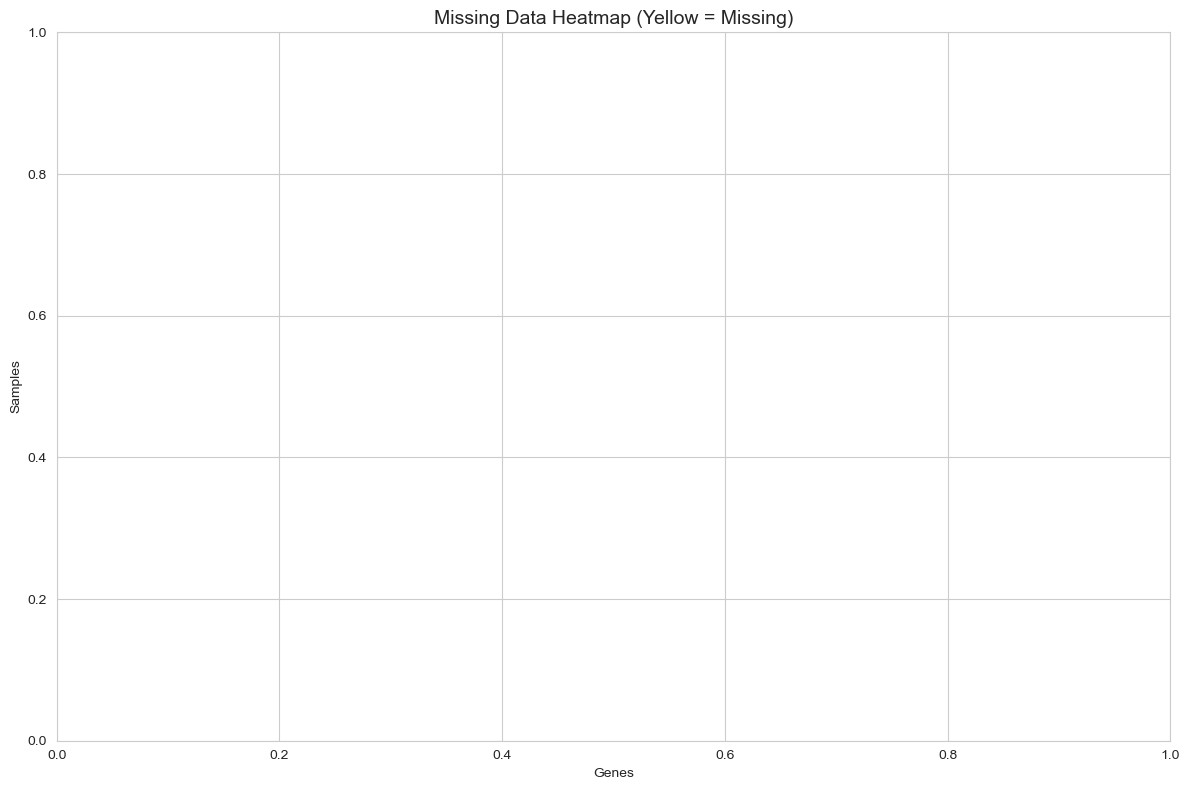

In [3]:
# Check for missing values
missing_summary = expression_df.isnull().sum()
print(f"Total missing values: {expression_df.isnull().sum().sum()}")
print(f"Percentage missing: {100 * expression_df.isnull().sum().sum() / expression_df.size:.2f}%")

# TODO: Create a heatmap of missing values using seaborn
# Hint: Use sns.heatmap with expression_df.isnull()
# Set cbar=False and use an appropriate colormap

plt.figure(figsize=(12, 8))
# YOUR CODE HERE

plt.title('Missing Data Heatmap (Yellow = Missing)', fontsize=14)
plt.xlabel('Genes')
plt.ylabel('Samples')
plt.tight_layout()
plt.show()

**Think About It**: 
- Are missing values random or concentrated in certain genes/samples?
- What might cause missing gene expression measurements in real experiments?

## Task 1.2: Handle Missing Values

Choose a strategy to handle missing values:
1. **Drop rows**: Remove samples with any missing values
2. **Mean imputation**: Fill with column mean
3. **Median imputation**: Fill with column median (more robust to outliers)

**Common Mistake**: Dropping too many samples reduces statistical power!

In [ ]:
# Make a copy to preserve original data
expr_cleaned = expression_df.copy()

# TODO: Implement median imputation for missing values
# Hint: Use sklearn's SimpleImputer for robust imputation
# Remember to exclude the 'sample_id' column

gene_columns = [col for col in expr_cleaned.columns if col != 'sample_id']

# YOUR CODE HERE
# Example approach:
# imputer = SimpleImputer(strategy='median')
# expr_cleaned[gene_columns] = imputer.fit_transform(expr_cleaned[gene_columns])

# Verify no missing values remain
print(f"Missing values after imputation: {expr_cleaned.isnull().sum().sum()}")
assert expr_cleaned.isnull().sum().sum() == 0, "Still have missing values!"

**Check Your Work**: The assertion should pass (no error means success!)

## Task 1.3: Detect and Remove Duplicate Samples

Duplicate samples violate the independence assumption in ML and can bias results.

**Key Insight**: Keep the first occurrence and drop subsequent duplicates.

In [ ]:
# Check for duplicates (excluding sample_id which should be unique)
print(f"Shape before removing duplicates: {expr_cleaned.shape}")
print(f"Number of duplicate rows: {expr_cleaned.duplicated(subset=gene_columns).sum()}")

# TODO: Remove duplicate rows based on gene expression values
# Hint: Use drop_duplicates() with subset=gene_columns
# Keep the first occurrence

# YOUR CODE HERE

print(f"Shape after removing duplicates: {expr_cleaned.shape}")
assert expr_cleaned.duplicated(subset=gene_columns).sum() == 0, "Still have duplicates!"

## Task 1.4: Identify and Handle Outliers

Outliers can be:
1. **Errors**: Measurement mistakes (should remove)
2. **Real biology**: True extreme values (should keep)

We'll visualize outliers using boxplots.

In [ ]:
# Visualize distribution of first 10 genes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, gene in enumerate(gene_columns[:10]):
    axes[i].boxplot(expr_cleaned[gene].dropna())
    axes[i].set_title(gene, fontsize=10)
    axes[i].set_ylabel('Expression')

plt.suptitle('Gene Expression Distributions (First 10 Genes)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n Notice: Some genes have very different scales and outliers!")

**Think About It**: 
- Which genes have outliers?
- Should we remove outliers or handle them with normalization?
- For this exercise, we'll handle outliers through normalization later.

## Task 1.5: Standardize Sample IDs

The sample IDs don't match between files! We need to standardize them.

**Common Mistake**: Ignoring ID mismatches leads to losing samples during merge.

In [ ]:
# Check current ID formats
print("Expression data sample IDs (first 10):")
print(expr_cleaned['sample_id'].head(10).tolist())
print("\nMetadata sample IDs (first 10):")
print(metadata_df['sample_id'].head(10).tolist())

# Check how many IDs match
matching_ids = set(expr_cleaned['sample_id']) & set(metadata_df['sample_id'])
print(f"\nCurrently matching IDs: {len(matching_ids)}")

In [ ]:
# TODO: Create a function to standardize sample IDs to 'SAMPLE_XXX' format
# Handle various formats: 'patient-1', 'Patient_01', 'sample-001', etc.

def standardize_sample_id(sample_id):
    """
    Standardize sample ID to 'SAMPLE_XXX' format.
    
    Examples:
    'patient-1' -> 'SAMPLE_001'
    'Patient_01' -> 'SAMPLE_001'
    'SAMPLE-002' -> 'SAMPLE_002'
    """
    # TODO: Implement standardization logic
    # Hints:
    # 1. Convert to uppercase
    # 2. Extract the numeric part
    # 3. Return formatted as 'SAMPLE_XXX' with zero-padding
    
    # YOUR CODE HERE
    pass

# Apply standardization
expr_cleaned['sample_id'] = expr_cleaned['sample_id'].apply(standardize_sample_id)
metadata_df['sample_id'] = metadata_df['sample_id'].apply(standardize_sample_id)

# Check matches now
matching_ids = set(expr_cleaned['sample_id']) & set(metadata_df['sample_id'])
print(f"Matching IDs after standardization: {len(matching_ids)}")

**Check Your Work**: You should have 100 matching IDs after standardization.

---
# Part 2: Data Labeling

Now let's prepare the labels for classification.

## Task 2.1: Inspect Label Inconsistencies

In [ ]:
# Examine unique diagnosis values
print("Unique diagnosis labels:")
print(metadata_df['diagnosis'].unique())
print("\nDiagnosis value counts:")
print(metadata_df['diagnosis'].value_counts())

**Key Insight**: We have inconsistent terminology!
- Cancer class: 'cancer', 'tumor', 'malignant', 'Cancer'
- Normal class: 'normal', 'healthy', 'control', 'Normal'
- Ambiguous: 'borderline', 'unclear', 'suspicious'

## Task 2.2: Map Labels to Binary Classification

Create binary labels: 0 = Normal, 1 = Cancer

In [ ]:
# TODO: Create a function to map diagnosis labels to binary (0 or 1)
# Return None for ambiguous cases

def map_diagnosis_to_binary(diagnosis):
    """
    Map diagnosis string to binary classification.
    
    Returns:
    - 0 for normal/healthy/control
    - 1 for cancer/tumor/malignant
    - None for ambiguous cases
    """
    diagnosis_lower = diagnosis.lower()
    
    # TODO: Implement mapping logic
    # YOUR CODE HERE
    pass

# Apply mapping
metadata_df['label'] = metadata_df['diagnosis'].apply(map_diagnosis_to_binary)

print("Label distribution:")
print(metadata_df['label'].value_counts())
print(f"\nAmbiguous cases: {metadata_df['label'].isnull().sum()}")

## Task 2.3: Handle Ambiguous Labels

**Think About It**: What should we do with ambiguous cases?

Options:
1. **Drop them**: Most conservative approach
2. **Assign to majority class**: Could introduce bias
3. **Use semi-supervised learning**: Advanced technique

For this exercise, we'll drop ambiguous cases.

In [ ]:
# TODO: Remove rows with ambiguous labels (where label is None/NaN)
# YOUR CODE HERE

print(f"Samples after removing ambiguous cases: {len(metadata_df)}")
assert metadata_df['label'].isnull().sum() == 0, "Still have ambiguous labels!"

## Task 2.4: Merge Expression Data with Labels

In [ ]:
# TODO: Merge expression data with metadata on 'sample_id'
# Use inner join to keep only samples present in both datasets
# YOUR CODE HERE
# full_data = ...

print(f"Final dataset shape: {full_data.shape}")
print(f"\nColumns: {full_data.columns.tolist()[:10]}...")  # Show first 10 columns

## Task 2.5: Visualize Class Distribution

In [ ]:
# TODO: Create a bar plot showing class distribution
# YOUR CODE HERE

plt.figure(figsize=(8, 5))
# Use full_data['label'].value_counts() and plot

plt.xlabel('Class (0=Normal, 1=Cancer)')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1])
plt.show()

# Calculate class balance
class_counts = full_data['label'].value_counts()
print(f"\nClass balance:")
print(f"Normal (0): {class_counts[0]} ({100*class_counts[0]/len(full_data):.1f}%)")
print(f"Cancer (1): {class_counts[1]} ({100*class_counts[1]/len(full_data):.1f}%)")

**Warning**: If classes are very imbalanced (e.g., 90/10), we'd need to address it with techniques like SMOTE or class weights.

## Task 2.6: Create Train/Validation/Test Splits

We'll use stratified splitting to maintain class balance:
- 60% training
- 20% validation  
- 20% test

**Key Insight**: Stratification ensures each split has similar class proportions.

In [ ]:
# Prepare features (X) and target (y)
X = full_data[gene_columns].values
y = full_data['label'].values.astype(int)  # Convert to int for proper bincount

# Safety check: Verify no NaN values
print(f"Checking for NaN values in features: {np.isnan(X).sum()}")
if np.isnan(X).sum() > 0:
    raise ValueError(f"Found {np.isnan(X).sum()} NaN values! Please complete Task 1.2 (missing value imputation) first.")

# TODO: Create train/temp split (60/40)
# Then split temp into validation/test (50/50 of temp = 20/20 of total)
# Use stratify parameter to maintain class balance
# Set random_state=42 for reproducibility

# YOUR CODE HERE
# X_train, X_temp, y_train, y_temp = train_test_split(...)
# X_val, X_test, y_val, y_test = train_test_split(...)

print("Split sizes:")
print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")

**Check Your Work**: Verify class balance in each split

In [ ]:
# Verify stratification worked
print("Class distribution in each split:")
print(f"\nTraining: {np.bincount(y_train)} -> {100*np.bincount(y_train)/len(y_train)}")
print(f"Validation: {np.bincount(y_val)} -> {100*np.bincount(y_val)/len(y_val)}")
print(f"Test: {np.bincount(y_test)} -> {100*np.bincount(y_test)/len(y_test)}")

---
# Part 3: Normalization and Its Impact

Now we'll see how normalization affects model performance.

## Task 3.1: Baseline Model (No Normalization)

First, let's train a model WITHOUT normalization to establish a baseline.

**Key Insight**: Features with larger scales will dominate the model.

In [ ]:
# Train logistic regression without normalization
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predict on validation set
y_val_pred_baseline = baseline_model.predict(X_val)

# Evaluate
baseline_acc = accuracy_score(y_val, y_val_pred_baseline)
print(f"Baseline Validation Accuracy: {baseline_acc:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_baseline))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_baseline, target_names=['Normal', 'Cancer']))

In [ ]:
# Visualize feature importance (model coefficients)
coef_baseline = baseline_model.coef_[0]

plt.figure(figsize=(12, 4))
plt.bar(range(len(coef_baseline)), coef_baseline)
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')
plt.title('Baseline Model Coefficients (No Normalization)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.show()

print(f"Coefficient range: [{coef_baseline.min():.6f}, {coef_baseline.max():.6f}]")

**Think About It**: 
- Why are some coefficients much larger than others?
- Can we fairly compare feature importance when features have different scales?

## Task 3.2: Min-Max Scaling

Min-Max scaling transforms features to [0, 1] range:
$$X_{scaled} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

**Critical**: Fit scaler on training data ONLY!

In [ ]:
# TODO: Apply Min-Max scaling
# 1. Create MinMaxScaler instance
# 2. Fit on training data
# 3. Transform train, validation, and test sets

# YOUR CODE HERE
# minmax_scaler = MinMaxScaler()
# X_train_minmax = ...
# X_val_minmax = ...
# X_test_minmax = ...

# Train model on scaled data
model_minmax = LogisticRegression(random_state=42, max_iter=1000)
model_minmax.fit(X_train_minmax, y_train)

# Evaluate
y_val_pred_minmax = model_minmax.predict(X_val_minmax)
minmax_acc = accuracy_score(y_val, y_val_pred_minmax)

print(f"Min-Max Scaling Validation Accuracy: {minmax_acc:.4f}")
print(f"Improvement over baseline: {minmax_acc - baseline_acc:+.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_minmax))

In [ ]:
# Visualize coefficients after Min-Max scaling
coef_minmax = model_minmax.coef_[0]

plt.figure(figsize=(12, 4))
plt.bar(range(len(coef_minmax)), coef_minmax, alpha=0.7)
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')
plt.title('Model Coefficients After Min-Max Scaling')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.show()

print(f"Coefficient range: [{coef_minmax.min():.4f}, {coef_minmax.max():.4f}]")

## Task 3.3: Standardization (Z-Score)

Standardization transforms features to have mean=0 and std=1:
$$X_{scaled} = \frac{X - \mu}{\sigma}$$

**Key Insight**: Unlike Min-Max, standardization isn't bounded to a specific range.

In [ ]:
# TODO: Apply Standardization
# Use StandardScaler from sklearn

# YOUR CODE HERE
# standard_scaler = StandardScaler()
# X_train_standard = ...
# X_val_standard = ...
# X_test_standard = ...

# Train model
model_standard = LogisticRegression(random_state=42, max_iter=1000)
model_standard.fit(X_train_standard, y_train)

# Evaluate
y_val_pred_standard = model_standard.predict(X_val_standard)
standard_acc = accuracy_score(y_val, y_val_pred_standard)

print(f"Standardization Validation Accuracy: {standard_acc:.4f}")
print(f"Improvement over baseline: {standard_acc - baseline_acc:+.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_standard))

In [ ]:
# Visualize coefficients
coef_standard = model_standard.coef_[0]

plt.figure(figsize=(12, 4))
plt.bar(range(len(coef_standard)), coef_standard, alpha=0.7, color='green')
plt.xlabel('Gene Index')
plt.ylabel('Coefficient')
plt.title('Model Coefficients After Standardization')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.show()

print(f"Coefficient range: [{coef_standard.min():.4f}, {coef_standard.max():.4f}]")

## Task 3.4: Log Transformation + Standardization

Gene expression data is often log-normally distributed. Let's try log transformation.

**Warning**: Can't take log of zero! Use log1p instead: log(1 + x)

**Important**: Make sure you completed Task 1.2 (missing value imputation) before running this cell!

In [ ]:
# Apply log transformation
# Note: log1p means log(1 + x) which handles zeros
# Gene expression should be non-negative
X_train_log = np.log1p(X_train)
X_val_log = np.log1p(X_val)
X_test_log = np.log1p(X_test)

# Then standardize
log_scaler = StandardScaler()
X_train_log_std = log_scaler.fit_transform(X_train_log)
X_val_log_std = log_scaler.transform(X_val_log)
X_test_log_std = log_scaler.transform(X_test_log)

# Train model
model_log = LogisticRegression(random_state=42, max_iter=1000)
model_log.fit(X_train_log_std, y_train)

# Evaluate
y_val_pred_log = model_log.predict(X_val_log_std)
log_acc = accuracy_score(y_val, y_val_pred_log)

print(f"Log + Standardization Validation Accuracy: {log_acc:.4f}")
print(f"Improvement over baseline: {log_acc - baseline_acc:+.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_log))

## Task 3.5: Compare All Normalization Methods

In [ ]:
# Create comparison table
results_df = pd.DataFrame({
    'Method': ['Baseline (No Norm)', 'Min-Max Scaling', 'Standardization', 'Log + Standardization'],
    'Validation Accuracy': [baseline_acc, minmax_acc, standard_acc, log_acc],
    'Improvement': [0, minmax_acc - baseline_acc, standard_acc - baseline_acc, log_acc - baseline_acc]
})

print("\n" + "="*70)
print("NORMALIZATION COMPARISON")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

In [ ]:
# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Method'], results_df['Validation Accuracy'], color=['red', 'blue', 'green', 'purple'], alpha=0.7)
plt.ylabel('Validation Accuracy')
plt.title('Model Performance: Impact of Normalization Methods')
plt.xticks(rotation=45, ha='right')
plt.ylim([0.5, 1.0])
plt.axhline(y=baseline_acc, color='red', linestyle='--', alpha=0.5, label='Baseline')
plt.legend()
plt.tight_layout()
plt.show()

**Think About It**:
- Which normalization method worked best?
- Why might log transformation be particularly appropriate for gene expression data?
- How much did normalization improve over the baseline?

---
# Part 4: Pipeline Integration

Sklearn pipelines help avoid data leakage and make code cleaner.

## Task 4.1: Build a Proper Pipeline

In [ ]:
# TODO: Create a pipeline with StandardScaler and LogisticRegression
# YOUR CODE HERE
# pipeline = Pipeline([
#     ('scaler', ...),
#     ('classifier', ...)
# ])

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Evaluate
y_val_pred_pipeline = pipeline.predict(X_val)
pipeline_acc = accuracy_score(y_val, y_val_pred_pipeline)

print(f"Pipeline Validation Accuracy: {pipeline_acc:.4f}")
print("\nPipeline steps:", pipeline.named_steps.keys())

## Task 4.2: Demonstrate Data Leakage Bug

**Common Mistake**: Normalizing before splitting data!

This leaks information from test set into training.

In [ ]:
# WRONG: Normalize entire dataset before split
print("WARNING: This demonstrates INCORRECT data handling!")
print("="*60)

# Normalize ALL data (data leakage!)
leaky_scaler = StandardScaler()
X_all_normalized = leaky_scaler.fit_transform(X)  # Fit on ALL data - BAD!

# Then split
X_train_leaky, X_temp_leaky, y_train_leaky, y_temp_leaky = train_test_split(
    X_all_normalized, y, test_size=0.4, stratify=y, random_state=42
)
X_val_leaky, X_test_leaky, y_val_leaky, y_test_leaky = train_test_split(
    X_temp_leaky, y_temp_leaky, test_size=0.5, stratify=y_temp_leaky, random_state=42
)

# Train model
leaky_model = LogisticRegression(random_state=42, max_iter=1000)
leaky_model.fit(X_train_leaky, y_train_leaky)
leaky_acc = accuracy_score(y_val_leaky, leaky_model.predict(X_val_leaky))

print(f"Leaky approach accuracy: {leaky_acc:.4f}")
print(f"Proper approach accuracy: {standard_acc:.4f}")
print(f"\nDifference: {leaky_acc - standard_acc:+.4f}")
print("\nLeaky accuracy may be artificially inflated!")
print("="*60)

**Key Insight**: Data leakage makes performance estimates unrealistically optimistic!

## Task 4.3: Final Evaluation on Test Set

Now let's evaluate our best model on the held-out test set.

In [ ]:
# Use the best normalization method (based on validation results)
# TODO: Choose your best model and evaluate on test set

# Example with standardization:
y_test_pred = model_standard.predict(X_test_standard)
test_acc = accuracy_score(y_test, y_test_pred)

print("="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)
print(f"Test Accuracy: {test_acc:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Cancer']))
print("="*60)

---
# Summary and Reflection

## What We Learned

1. **Data Cleaning is Critical**
   - Missing values, duplicates, and outliers are common
   - Each issue requires thoughtful handling
   - Document your decisions!

2. **Label Quality Matters**
   - Inconsistent labels prevent learning
   - Ambiguous cases need careful consideration
   - Stratification maintains class balance

3. **Normalization Improves Performance**
   - Features with different scales bias models
   - Different normalization methods suit different data
   - Always fit on training data only!

4. **Pipelines Prevent Mistakes**
   - Encapsulate preprocessing steps
   - Avoid data leakage
   - Make code reproducible

## Key Takeaways

- **Data quality** often matters more than model choice
- **Preprocessing** is not optional for real-world data
- **Data leakage** is easy to introduce and hard to detect
- **Documentation** helps reproduce and explain results

## Bonus Challenge

Try these extensions:

1. **Different Models**: Try RandomForestClassifier or SVM
2. **Cross-Validation**: Use 5-fold CV instead of single validation set
3. **Feature Selection**: Identify the 10 most important genes
4. **Dimensionality Reduction**: Apply PCA before classification
5. **Class Imbalance**: If you had 90/10 split, how would you handle it?
6. **Error Analysis**: Which samples are misclassified and why?

## Your Reflection

Answer these questions:

1. Which preprocessing step had the biggest impact on your model?
2. What surprised you most in this exercise?
3. How would you handle these issues in a real research project?
4. What additional data quality checks would you add?

**YOUR REFLECTION HERE:**

_[Write your thoughts]_

---
## Congratulations!

You've completed the ML fundamentals exercise. You now understand:
- How to clean messy real-world data
- Why normalization matters
- How to avoid data leakage
- The importance of proper preprocessing pipelines

These skills are essential for any machine learning project!